In [15]:
import sys
from collections import defaultdict
from scipy.stats import kendalltau
import pandas as pd

import numpy as np
from tqdm import tqdm

from pathlib import Path
sys.path.append("../")
from src.proxann.utils import process_responses, collect_fit_rank_data, compute_correlations_one, compute_correlations, loo_from_corr_data, read_json, compute_bradley_terry

In [16]:
data_jsons = [
    "../data/data_used_in_paper/json_out/config_wiki_part1.json",
    "../data/data_used_in_paper/json_out/config_wiki_part2.json",
    "../data/data_used_in_paper/json_out/config_bills_part1.json",
    "../data/data_used_in_paper/json_out/config_bills_part2.json",
]
response_csvs = [
    "../data/human_annotations/Cluster+Evaluation+-+Sort+and+Rank+-+Bills_December+14,+2024_13.20.csv",
    "../data/human_annotations/Cluster+Evaluation+-+Sort+and+Rank_December+12,+2024_05.19.csv",
]
start_date = "2024-12-06 09:00:00"

responses = {}
for csv in response_csvs:
    for topic_id, topic_responses in process_responses(csv, data_jsons, start_date=start_date, path_save=None, removal_condition="loose").items():
        if topic_responses:
            responses[topic_id] = topic_responses

_, _, _, corr_data = collect_fit_rank_data(responses)
corr_data = sorted(corr_data, key=lambda x: x["id"])
corr_ids = [x["id"] for x in corr_data]

base_path =  Path("../data/camera_ready_llm_out/mean/")
llm_data_patterns = {
    "gpt-4o": {
        "wiki": list(Path(base_path, "wiki/gpt-4o-2024-08-06/").glob("*")),
        "bills": list(Path(base_path, "bills/gpt-4o-2024-08-06/").glob("*")),
    },
    "llama-8b": {
        "wiki": list(Path(base_path, "wiki/Meta-Llama-3.1-8B-Instruct").glob("*")),
        "bills": list(Path(base_path, "bills/Meta-Llama-3.1-8B-Instruct").glob("*")),
    },
    "llama-70b": {
        "wiki": list(Path(base_path, "wiki/llama-3.3-70b-instruct-awq/").glob("*")),
        "bills": list(Path(base_path, "bills/llama-3.3-70b-instruct-awq/").glob("*")),
    },
    "qwen-2.5-72b": {
        "wiki": list(Path(base_path, "wiki/Qwen2.5-72B-Instruct-AWQ/").glob("*")),
        "bills": list(Path(base_path, "bills/Qwen2.5-72B-Instruct-AWQ/").glob("*")),
    },
    "qwen-3-8b": {
        "wiki": list(Path(base_path, "wiki/Qwen3-8B/").glob("*")),
        "bills": list(Path(base_path, "bills/Qwen3-8B/").glob("*")),
    },
    "qwen-3-32b": {
        "wiki": list(Path(base_path, "wiki/Qwen3-32B/").glob("*")),
        "bills": list(Path(base_path, "bills/Qwen3-32B/").glob("*")),
    },
}

Total responses: 121
Total responses: 121
Removed: 20
Total responses: 142
Total responses: 142
Removed: 25


In [17]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

llm_fits, llm_ranks, llm_wins = {}, {}, {}
for llm, paths_by_ds in llm_data_patterns.items():
    llm_fits[llm] = defaultdict(list)
    llm_ranks[llm] = defaultdict(list)
    llm_wins[llm] = defaultdict(list)

    for dataset, paths in paths_by_ds.items():
        fits_, ranks_, wins_ = [], [], []
        # iterate over all seeds
        for seed, path in enumerate(paths):
            fits_seed = read_json(f"{path}/llm_results_q2.json")
            ranks_seed = read_json(f"{path}/llm_results_q3.json")
            wins_seed = read_json(f"{path}/all_info_bradley_terry.json")

            # point is to move from "seed by topic"
            # [[topic_0_seed_0, topic_1_seed_0, ...], [topic_0_seed_1, topic_1_seed_1, ...]]
            # to "topic by seed"
            # [[topic_0_seed_0, topic_0_seed_1, ...], [topic_1_seed_0, topic_1_seed_1, ...]]
            for i, (fit_item, rank_item, win_item) in enumerate(zip(fits_seed, ranks_seed, wins_seed)):
                assert(fit_item["id"] == rank_item["id"] == win_item["id"])
                if seed == 0:
                    fits_.append([fit_item])
                    ranks_.append([rank_item])
                    wins_.append([win_item])
                else:
                    fits_[i].append(fit_item)
                    ranks_[i].append(rank_item)
                    wins_[i].append(win_item)

        # then we can average over all seeds
        for fit_item, rank_item, win_item in zip(fits_, ranks_, wins_):
            item_id = fit_item[0]["id"]
            llm_fits[llm][dataset].append({
                "id": item_id,
                "annotators": [llm],
                "fit_data": [np.mean([x["fit_data"][0] for x in fit_item], axis=0).tolist()],
            })
            llm_ranks[llm][dataset].append({
                "id": item_id,
                "annotators": [llm],
                "rank_data": [np.mean([x["rank_data"][0] for x in rank_item], axis=0).tolist()],
            })
            
            # re-compute bradley terry across the full collection
            rank = compute_bradley_terry(win_item, responses, item_id, combine_runs=True)

            llm_wins[llm][dataset].append({
                "id": item_id,
                "annotators": [llm],
                "rank_data": [rank],
            })

In [18]:
task = "fit"
metric = "agree"
agg = "mean"

for model in llm_data_patterns:
    for ds in ["wiki", "bills"]:
        corrs_ds = compute_correlations(
            corr_data=corr_data,
            rank_llm_data=llm_ranks[model][ds],
            fit_llm_data=llm_fits[model][ds],
            aggregation_method=agg,
            fit_threshold_user=4, # 3 may be better?
            fit_threshold_llm=4,
            rescale_ndcg=True,
        )
        combined_user_metric = corrs_ds[f"{task}_{metric}_users_{model}"]
        combined_tm_metric = corrs_ds[f"{task}_{metric}_tm_{model}"]
        user_tm_metric = corrs_ds[f"{task}_{metric}"]

        tau_topic_rank = kendalltau(combined_tm_metric.values, user_tm_metric.values, nan_policy="omit").statistic
        print(f"{model} combined mean, {ds:5} llm-user {combined_user_metric.mean():0.3f}, tau topics {tau_topic_rank:0.3f}")

gpt-4o combined mean, wiki  llm-user 0.780, tau topics 0.288
gpt-4o combined mean, bills llm-user 0.714, tau topics 0.252
llama-8b combined mean, wiki  llm-user 0.429, tau topics -0.374
llama-8b combined mean, bills llm-user 0.446, tau topics -0.034
llama-70b combined mean, wiki  llm-user 0.810, tau topics 0.485
llama-70b combined mean, bills llm-user 0.768, tau topics 0.239
qwen-2.5-72b combined mean, wiki  llm-user 0.768, tau topics 0.376
qwen-2.5-72b combined mean, bills llm-user 0.667, tau topics 0.360
qwen-3-8b combined mean, wiki  llm-user 0.810, tau topics 0.450
qwen-3-8b combined mean, bills llm-user 0.774, tau topics 0.395
qwen-3-32b combined mean, wiki  llm-user 0.839, tau topics 0.446
qwen-3-32b combined mean, bills llm-user 0.732, tau topics 0.325


In [19]:
cohr_path = ["/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/data/cohrs/all_cohrs_bills.csv", "/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/data/cohrs/all_cohrs_wiki.csv"]
cohrs = pd.concat([pd.read_csv(cohr_path[0]), pd.read_csv(cohr_path[1])]).to_dict(orient="records")

In [20]:
models = ["llama-8b", "qwen-3-8b", "qwen-3-32b", "llama-70b", "qwen-2.5-72b", "gpt-4o"]

## Table 4

In [21]:
corr_metric = "tau" #"tau"
agg = "mean"
binarize_tm_probs = True
n_resample_annotators = 1
n_resample_topics = 50

row_names = ["npmi", "cv"] + [f"{metric}_{llm}" for llm in models for metric in ["fit", "rank"]] + ["human"]
column_names = [f"{metric}_{ds}" for ds in ["wiki", "bills"] for metric in ["fit", "rank"]]
results_df = pd.DataFrame(index=row_names, columns=column_names)

# Bootstrap correlations
for ds in ["wiki", "bills"]:
    print(f"Processing {ds}...")
    corr_data_ds = [x for x in corr_data if ds in x["id"]]
    filtered_cohrs = sorted([x for x in cohrs if x["id"] in [c["id"] for c in corr_data_ds]], key=lambda x: x["id"])
    npmi_cohrs = [x["npmi"] for x in filtered_cohrs]
    cv_cohrs = [x["cv"] for x in filtered_cohrs]

    for model in models:
        rng = np.random.RandomState(42)
        all_corrs = {m1: {m2: [] for m2 in ["fit", "rank"]} for m1 in ["fit", "rank"]}
        npmi_corrs = {m: [] for m in ["fit", "rank"]}
        cv_corrs = {m: [] for m in ["fit", "rank"]}

        for i in range(n_resample_annotators):
            corrs_ds = compute_correlations(
                corr_data=corr_data,
                rank_llm_data=llm_ranks[model][ds],
                fit_llm_data=llm_fits[model][ds],
                aggregation_method=agg,
                fit_threshold_user=4,
                fit_threshold_llm=4,
                binarize_tm_probs=binarize_tm_probs,
                rescale_ndcg=True,
                bootstrap_annotators=n_resample_annotators > 1,
                seed=rng._bit_generator,
            )

            for j in range(n_resample_topics):
                corrs_ds_j = corrs_ds.sample(frac=1, random_state=rng._bit_generator, replace=True) \
                    if n_resample_topics > 1 else corrs_ds

                corrs_ds_j = corrs_ds_j.sort_values("id").reset_index(drop=True)
                for user_metric in ["fit", "rank"]:
                    user_tm_metric = corrs_ds_j[f"{user_metric}_{corr_metric}"]

                    # npmi/cv correlation
                    npmi_tau = kendalltau(npmi_cohrs, user_tm_metric, nan_policy="omit").statistic
                    cv_tau = kendalltau(cv_cohrs, user_tm_metric, nan_policy="omit").statistic
                    npmi_corrs[user_metric].append(npmi_tau)
                    cv_corrs[user_metric].append(cv_tau)

                    for llm_metric in ["fit", "rank"]:
                        llm_tm_metric = corrs_ds_j[f"{llm_metric}_{corr_metric}_tm_{model}"]
                        tau = kendalltau(llm_tm_metric, user_tm_metric, nan_policy="omit").statistic
                        all_corrs[llm_metric][user_metric].append(tau)

        # Save mean ± std to results_df
        for user_metric in ["fit", "rank"]:
            results_df.loc["npmi", f"{user_metric}_{ds}"] = f"{np.mean(npmi_corrs[user_metric]):.2f} $\\pm$ {np.std(npmi_corrs[user_metric]):.2f}"
            results_df.loc["cv", f"{user_metric}_{ds}"] = f"{np.mean(cv_corrs[user_metric]):.2f} $\\pm$ {np.std(cv_corrs[user_metric]):.2f}"

            for llm_metric in ["fit", "rank"]:
                val_list = all_corrs[llm_metric][user_metric]
                results_df.loc[f"{llm_metric}_{model}", f"{user_metric}_{ds}"] = f"{np.mean(val_list):.2f} $\\pm$ {np.std(val_list):.2f}"

# Human consistency
resample_data = []

for ds in ["wiki", "bills"]:
    for _ in tqdm(range(100), desc=f"Human bootstrap {ds}"):
        corr_data_ds = [x for x in corr_data if ds in x["id"]]
        loo_corr_data_a = loo_from_corr_data(corr_data_ds, seed=None)
        annotators_to_retain = {x["id"]: x["dropped"] for x in loo_corr_data_a}
        corrs_a = compute_correlations_one(loo_corr_data_a).sort_values("id")
        loo_corr_data_b = loo_from_corr_data(corr_data_ds, seed=None, annotators_to_retain=annotators_to_retain, keep_one=True)
        corrs_b = compute_correlations_one(loo_corr_data_b).sort_values("id")

        resample_data.append({
            "ds": ds,
            "tau_of_rank_tau": kendalltau(corrs_a["rank_tau"].values, corrs_b["rank_tau"].values).statistic,
            "tau_of_fit_tau": kendalltau(corrs_a["fit_tau"].values, corrs_b["fit_tau"].values).statistic,
        })

resample_df = pd.DataFrame(resample_data)
resample_means = resample_df.groupby("ds").mean()
resample_stds = resample_df.groupby("ds").std()

for ds in ["wiki", "bills"]:
    results_df.loc["human", f"fit_{ds}"] = f"{resample_means.loc[ds, 'tau_of_fit_tau']:.2f} $\\pm$ {resample_stds.loc[ds, 'tau_of_fit_tau']:.2f}"
    results_df.loc["human", f"rank_{ds}"] = f"{resample_means.loc[ds, 'tau_of_rank_tau']:.2f} $\\pm$ {resample_stds.loc[ds, 'tau_of_rank_tau']:.2f}"


results_df

Processing wiki...


TypeError: compute_correlations() got an unexpected keyword argument 'binarize_tm_probs'

In [ ]:
def generate_table_from_results_df(
    data_df,
    datasets=["Wiki", "Bills"],
    cohr_metrics=["$C_{NPMI}$"],
    human_metrics=["Human\\ Fit", "Human\\ Rank"],
    model_mapping=None,
):

    #Header Rows
    nr_left_columns = 2
    headers_first_level = (
        [""] * nr_left_columns
        + [f"\\multicolumn{{2}}{{c}}{{\\texttt{{{dataset}}}}}" for dataset in datasets]
    )
    headers_second_level = (
        ["", ""]
        + [f"\\makecell{{{metric}}}" for _ in datasets for metric in human_metrics]
    )
    column_format = "ll" + "c" * len(datasets) * len(human_metrics)
    cmidrules = [
        rf"\cmidrule(lr){{{nr_left_columns + i * len(human_metrics) + 1}-{nr_left_columns + i * len(human_metrics) + len(human_metrics)}}}"
        for i in range(len(datasets))
    ]

    col_map = {
        f"{metric}_{ds.lower()}": (ds, human_metrics[0] if metric == "fit" else human_metrics[1])
        for ds in datasets for metric in ["fit", "rank"]
    }
    selected_cols = list(col_map.keys())

    df = data_df[selected_cols].copy()
    df.columns = pd.MultiIndex.from_tuples([col_map[c] for c in selected_cols])

    def get_model_rows(prefix):
        rows = []
        for idx in df.index:
            if idx.startswith(f"{prefix}_"):
                model_key = idx[len(prefix) + 1:]
                model_name = model_mapping.get(model_key, model_key).replace("_", "\\_")
                rows.append((model_name, df.loc[idx].tolist()))
        return rows

    fit_rows = get_model_rows("fit")
    rank_rows = get_model_rows("rank")

    # human
    human_vals = df.loc["human"].tolist()
    fit_rows.append(("Human", human_vals))
    rank_rows.append(("Human", human_vals))

    cohr_index_map = {
        "$C_{NPMI}$": "npmi",
        "$C_{V}$": "cv"
    }

    cohr_rows = []
    for metric in cohr_metrics:
        row_key = cohr_index_map.get(metric, metric)
        if row_key not in df.index:
            raise ValueError(f"Coherence metric '{metric}' could not be found in DataFrame index.")
        cohr_rows.append(("Cohr.", metric, df.loc[row_key].tolist()))

    def fmt_row(label1, label2, values):
        val_str = " & ".join(str(v) if pd.notna(v) else "--" for v in values)
        return f"{label1} & {label2} & {val_str} \\\\"

    latex = rf"""
\begin{{tabular}}{{@{{}}{column_format}@{{}}}}
\toprule
{" & ".join(headers_first_level)} \\
{"".join(cmidrules)}
{" & ".join(headers_second_level)} \\
\midrule
"""

    # Coherence block
    for i, (lbl1, lbl2, vals) in enumerate(cohr_rows):
        latex += fmt_row(lbl1 if i == 0 else "", lbl2, vals) + "\n"

    latex += "\\midrule\n"

    # Fit block
    n_fit = len(fit_rows)
    for i, (name, vals) in enumerate(fit_rows):
        if name != "Human":
            name = name.replace("_", "\\_")
            label1 = rf"\multirow{{{n_fit}}}{{*}}{{\makecell{{Model\\Fit}}}}" if i == 0 else ""
            label2 = name
            latex += fmt_row(label1, label2, vals) + "\n"

    latex += "\\midrule\n"

    # Rank block 
    n_rank = len(rank_rows)
    for i, (name, vals) in enumerate(rank_rows):
        if name != "Human":
            label1 = rf"\multirow{{{n_rank}}}{{*}}{{\makecell{{Model\\Rank}}}}" if i == 0 else ""
            label2 = name
            latex += fmt_row(label1, label2, vals) + "\n"
            
    latex += "\\midrule\n"
    for i, (name, vals) in enumerate(fit_rows):
        if name == "Human":
            latex += fmt_row(name, "", vals) + "\n"

    latex += "\\bottomrule\n\\end{tabular}"
    return latex


In [ ]:
def generate_table_from_results_df_without_diagonals(
    data_df,
    datasets=["Wiki", "Bills"],
    cohr_metrics=["$C_{NPMI}$"],
    human_metrics=["Human\\ Fit", "Human\\ Rank"],
    model_mapping=None
):
    
    nr_left_columns = 1
    headers_first_level = (
        [""] + [f"\\multicolumn{{2}}{{c}}{{\\texttt{{{dataset}}}}}" for dataset in datasets]
    )
    headers_second_level = (
        [""] + [f"{metric}" for _ in datasets for metric in human_metrics]
    )
    column_format = "l" + "c" * len(datasets) * len(human_metrics)
    cmidrules = [
        rf"\cmidrule(lr){{{nr_left_columns + i * 2 + 1}-{nr_left_columns + i * 2 + 2}}}"
        for i in range(len(datasets))
    ]

    col_map = {
        f"{stat}_{ds.lower()}": (ds, human_metrics[0] if stat == "fit" else human_metrics[1])
        for ds in datasets for stat in ["fit", "rank"]
    }
    df = data_df[list(col_map)].copy()
    df.columns = pd.MultiIndex.from_tuples([col_map[c] for c in df.columns])


    model_rows = defaultdict(lambda: ["" for _ in range(len(datasets) * len(human_metrics))])

    def get_model_label(model_key):
        return model_mapping.get(model_key, model_key).replace("_", "\\_") if model_mapping else model_key

    for idx in df.index:
        if idx.startswith("fit_") or idx.startswith("rank_"):
            model_key = idx.split("_", 1)[1]
            col_type = "fit" if idx.startswith("fit_") else "rank"
            for d_idx, ds in enumerate(datasets):
                col_pos = d_idx * 2 + (0 if col_type == "fit" else 1)
                val = df.loc[idx, (ds, human_metrics[0 if col_type == "fit" else 1])]
                if pd.notna(val):
                    model_rows[get_model_label(model_key)][col_pos] = val

    # Human row
    if "human" in df.index:
        human_vals = df.loc["human"].tolist()
        model_rows["Human"] = human_vals

    # Coherence row ---
    cohr_index_map = {
        "$C_{NPMI}$": "npmi",
        "$C_{V}$": "cv"
    }
    cohr_rows = []
    for metric in cohr_metrics:
        row_key = cohr_index_map.get(metric, metric)
        if row_key in df.index:
            cohr_rows.append((metric, df.loc[row_key].tolist()))

    def fmt_row(label, values):
        val_str = " & ".join(str(v) if v != "" else "" for v in values)
        return f"{label} & {val_str} \\\\"

    latex = rf"""
\begin{{tabular}}{{@{{}}{column_format}@{{}}}}
\toprule
{" & ".join(headers_first_level)} \\
{"".join(cmidrules)}
{" & ".join(headers_second_level)} \\
\midrule
"""

    for metric, vals in cohr_rows:
        latex += fmt_row(metric, vals) + "\n"

    latex += "\\midrule\n"

    for name, vals in model_rows.items():
        latex += fmt_row(name, vals) + "\n"

    latex += "\\bottomrule\n\\end{tabular}"
    return latex


In [ ]:
latex_code = generate_table_from_results_df(
    data_df=results_df,
    datasets=["Wiki", "Bills"],
    cohr_metrics=["$C_{NPMI}$"],
    human_metrics=["Human\\ Fit", "Human\\ Rank"],
    model_mapping={
    "llama-8b": "Llama-3.1-8B",
    "qwen-3-8b": "Qwen-3-8B",
    "qwen-3-32b": "Qwen-3-32B",
    "llama-70b": "Llama-3.3-70B",
    "qwen-2.5-72b": "Qwen-2.5-72B",
    "gpt-4o": "GPT-4o"
}

)
print(latex_code)


\begin{tabular}{@{}llcccc@{}}
\toprule
 &  & \multicolumn{2}{c}{\texttt{Wiki}} & \multicolumn{2}{c}{\texttt{Bills}} \\
\cmidrule(lr){3-4}\cmidrule(lr){5-6}
 &  & \makecell{Human\ Fit} & \makecell{Human\ Rank} & \makecell{Human\ Fit} & \makecell{Human\ Rank} \\
\midrule
Cohr. & $C_{NPMI}$ & -0.08 $\pm$ 0.13 & -0.17 $\pm$ 0.10 & 0.04 $\pm$ 0.08 & -0.01 $\pm$ 0.12 \\
\midrule
\multirow{7}{*}{\makecell{Model\\Fit}} & Llama-3.1-8B & 0.06 $\pm$ 0.17 & 0.12 $\pm$ 0.17 & 0.19 $\pm$ 0.14 & 0.12 $\pm$ 0.14 \\
 & Qwen-3-8B & 0.72 $\pm$ 0.08 & 0.53 $\pm$ 0.13 & 0.39 $\pm$ 0.12 & 0.34 $\pm$ 0.09 \\
 & Qwen-3-32B & 0.47 $\pm$ 0.18 & 0.54 $\pm$ 0.14 & 0.61 $\pm$ 0.09 & 0.49 $\pm$ 0.12 \\
 & Llama-3.3-70B & 0.66 $\pm$ 0.10 & 0.45 $\pm$ 0.10 & 0.42 $\pm$ 0.15 & 0.29 $\pm$ 0.11 \\
 & Qwen-2.5-72B & 0.63 $\pm$ 0.11 & 0.54 $\pm$ 0.13 & 0.41 $\pm$ 0.11 & 0.39 $\pm$ 0.11 \\
 & GPT-4o & 0.55 $\pm$ 0.13 & 0.53 $\pm$ 0.15 & 0.43 $\pm$ 0.11 & 0.54 $\pm$ 0.08 \\
\midrule
\multirow{7}{*}{\makecell{Model\\Rank}} 

In [ ]:
latex_code = generate_table_from_results_df_without_diagonals(
    data_df=results_df,
    datasets=["Wiki", "Bills"],
    cohr_metrics=["$C_{NPMI}$"],
    #human_metrics=["Human\\ Fit", "Human\\ Rank"],
    model_mapping={
    "llama-8b": "Llama-3.1-8B",
    "qwen-3-8b": "Qwen-3-8B",
    "qwen-3-32b": "Qwen-3-32B",
    "llama-70b": "Llama-3.3-70B",
    "qwen-2.5-72b": "Qwen-2.5-72B",
    "gpt-4o": "GPT-4o"
}

)
print(latex_code)


\begin{tabular}{@{}lcccc@{}}
\toprule
 & \multicolumn{2}{c}{\texttt{Wiki}} & \multicolumn{2}{c}{\texttt{Bills}} \\
\cmidrule(lr){2-3}\cmidrule(lr){4-5}
 & Human\ Fit & Human\ Rank & Human\ Fit & Human\ Rank \\
\midrule
$C_{NPMI}$ & -0.08 $\pm$ 0.13 & -0.17 $\pm$ 0.10 & 0.04 $\pm$ 0.08 & -0.01 $\pm$ 0.12 \\
\midrule
Llama-3.1-8B & 0.06 $\pm$ 0.17 & -0.23 $\pm$ 0.14 & 0.19 $\pm$ 0.14 & 0.20 $\pm$ 0.16 \\
Qwen-3-8B & 0.72 $\pm$ 0.08 & 0.32 $\pm$ 0.17 & 0.39 $\pm$ 0.12 & 0.35 $\pm$ 0.11 \\
Qwen-3-32B & 0.47 $\pm$ 0.18 & 0.55 $\pm$ 0.14 & 0.61 $\pm$ 0.09 & 0.49 $\pm$ 0.08 \\
Llama-3.3-70B & 0.66 $\pm$ 0.10 & 0.52 $\pm$ 0.13 & 0.42 $\pm$ 0.15 & 0.20 $\pm$ 0.12 \\
Qwen-2.5-72B & 0.63 $\pm$ 0.11 & 0.52 $\pm$ 0.12 & 0.41 $\pm$ 0.11 & 0.32 $\pm$ 0.11 \\
GPT-4o & 0.55 $\pm$ 0.13 & 0.35 $\pm$ 0.13 & 0.43 $\pm$ 0.11 & 0.47 $\pm$ 0.11 \\
Human & 0.42 $\pm$ 0.09 & 0.33 $\pm$ 0.08 & 0.10 $\pm$ 0.12 & 0.18 $\pm$ 0.10 \\
\bottomrule
\end{tabular}


# For Figure

In [ ]:
corr_metric = "tau" #"tau"
agg = "mean"
∑ = True
n_resample_annotators = 1
n_resample_topics = 50

# new results_df
column_names = ["human_fit", "human_rank"] + ["npmi", "cv"] + \
[f"{llm}_{metric}" for llm in models for metric in ["fit", "rank"]]
row_names = ["mallet", "ctm", "bertopic"]

dataset_statistics = defaultdict(pd.DataFrame)

# Bootstrap correlations
for ds in ["wiki", "bills"]:
    
    results_df = pd.DataFrame(index=row_names, columns=column_names)
    
    # create intermediate dictionaries to save results previous to mean
    # one per topic model (model); for each model, we save fit and rank metrics
    human_metrics = defaultdict(lambda: defaultdict(list))
    # one per topic model (model); for each model, we save for each llm fit and rank metrics
    llm_metrics = defaultdict(lambda: defaultdict(list))
    
    print(f"Processing {ds}...")

    for llm in models:
        print(f"Processing {llm}...")
        rng = np.random.RandomState(42)
        
        for i in range(n_resample_annotators):
            corrs_ds = compute_correlations(
                corr_data=corr_data,
                rank_llm_data=llm_ranks[llm][ds],
                fit_llm_data=llm_fits[llm][ds],
                aggregation_method=agg,
                fit_threshold_user=4,
                fit_threshold_llm=4,
                binarize_tm_probs=binarize_tm_probs,
                rescale_ndcg=True,
                bootstrap_annotators=n_resample_annotators > 1,
                seed=rng._bit_generator,
            )

            for j in range(n_resample_topics):
                corrs_ds_j = corrs_ds.sample(frac=1, random_state=rng._bit_generator, replace=True) \
                    if n_resample_topics > 1 else corrs_ds

                corrs_ds_j = corrs_ds_j.sort_values("id").reset_index(drop=True)
                
                for user_metric in ["fit", "rank"]:
                    
                    user_tm_metric_name = f"{user_metric}_{corr_metric}"
                    user_tm_metric = corrs_ds_j[["id", user_tm_metric_name]]
                    
                    # filter by model (topic model) type
                    for model_name in row_names:
                        human_metrics[model_name][user_metric].append(
                            user_tm_metric[user_tm_metric["id"].str.contains(model_name)][user_tm_metric_name].mean()
                        )
                
                for llm_metric in ["fit", "rank"]:
                    
                    llm_tm_metric_name = f"{llm_metric}_{corr_metric}_tm_{llm}"
                    llm_tm_metric = corrs_ds_j[["id", llm_tm_metric_name]]
                    
                    for model_name in row_names:
                        llm_metrics[model_name][f"{llm}_{llm_metric}"].append(
                            llm_tm_metric[llm_tm_metric["id"].str.contains(model_name)][llm_tm_metric_name].mean()
                        )

    for model_name in row_names:
        for user_metric in ["fit", "rank"]:
            values = human_metrics[model_name][user_metric]
            mean = np.mean(values)
            ci_low = np.percentile(values, 2.5)
            ci_high = np.percentile(values, 97.5)

            results_df.loc[model_name, f"human_{user_metric}"] = mean
            results_df.loc[model_name, f"human_{user_metric}_ci_low"] = ci_low
            results_df.loc[model_name, f"human_{user_metric}_ci_high"] = ci_high

        for llm_metric_key, values in llm_metrics[model_name].items():
            mean = np.mean(values)
            ci_low = np.percentile(values, 2.5)
            ci_high = np.percentile(values, 97.5)

            results_df.loc[model_name, llm_metric_key] = mean
            results_df.loc[model_name, f"{llm_metric_key}_ci_low"] = ci_low
            results_df.loc[model_name, f"{llm_metric_key}_ci_high"] = ci_high

    cohrs_df = pd.DataFrame(cohrs)

    for cohr in ["npmi", "cv"]:    
        cohrs_df = cohrs_df[cohrs_df["id"].str.contains(ds)]
        for model_name in row_names:
            # filter cohrs by model type
            cohrs_model = cohrs_df[cohrs_df["id"].str.contains(model_name)]
            results_df.loc[model_name, cohr] = cohrs_model[cohr].mean()
            
    results_df.index.name = "model"
    results_df = results_df.reset_index()
    dataset_statistics[ds] = results_df

Processing wiki...
Processing llama-8b...
Processing qwen-3-8b...
Processing qwen-3-32b...
Processing llama-70b...
Processing qwen-2.5-72b...
Processing gpt-4o...
Processing bills...
Processing llama-8b...
Processing qwen-3-8b...
Processing qwen-3-32b...
Processing llama-70b...
Processing qwen-2.5-72b...
Processing gpt-4o...


In [ ]:
print("Wiki dataset")
print(dataset_statistics["wiki"].to_string())
print("Bills dataset")
print(dataset_statistics["bills"].to_string())

Wiki dataset
      model human_fit human_rank      npmi        cv llama-8b_fit llama-8b_rank qwen-3-8b_fit qwen-3-8b_rank qwen-3-32b_fit qwen-3-32b_rank llama-70b_fit llama-70b_rank qwen-2.5-72b_fit qwen-2.5-72b_rank gpt-4o_fit gpt-4o_rank  human_fit_ci_low  human_fit_ci_high  human_rank_ci_low  human_rank_ci_high  llama-8b_fit_ci_low  llama-8b_fit_ci_high  llama-8b_rank_ci_low  llama-8b_rank_ci_high  qwen-3-8b_fit_ci_low  qwen-3-8b_fit_ci_high  qwen-3-8b_rank_ci_low  qwen-3-8b_rank_ci_high  qwen-3-32b_fit_ci_low  qwen-3-32b_fit_ci_high  qwen-3-32b_rank_ci_low  qwen-3-32b_rank_ci_high  llama-70b_fit_ci_low  llama-70b_fit_ci_high  llama-70b_rank_ci_low  llama-70b_rank_ci_high  qwen-2.5-72b_fit_ci_low  qwen-2.5-72b_fit_ci_high  qwen-2.5-72b_rank_ci_low  qwen-2.5-72b_rank_ci_high  gpt-4o_fit_ci_low  gpt-4o_fit_ci_high  gpt-4o_rank_ci_low  gpt-4o_rank_ci_high
0    mallet  0.673768   0.740288   0.12573  0.686326     0.500519      0.069394      0.688438       0.727548       0.727378        0

Saving plot with binarized ACL probabilities...


/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 22 x 8 in image.
/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/all_metrics_models_comparison_tau_binarized_acl.pdf
/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 12 rows containing missing values.
/export/usuarios_ml4ds/lbartolome/Repos/umd/theta-evaluation/.venv/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 12 rows containing missing values.


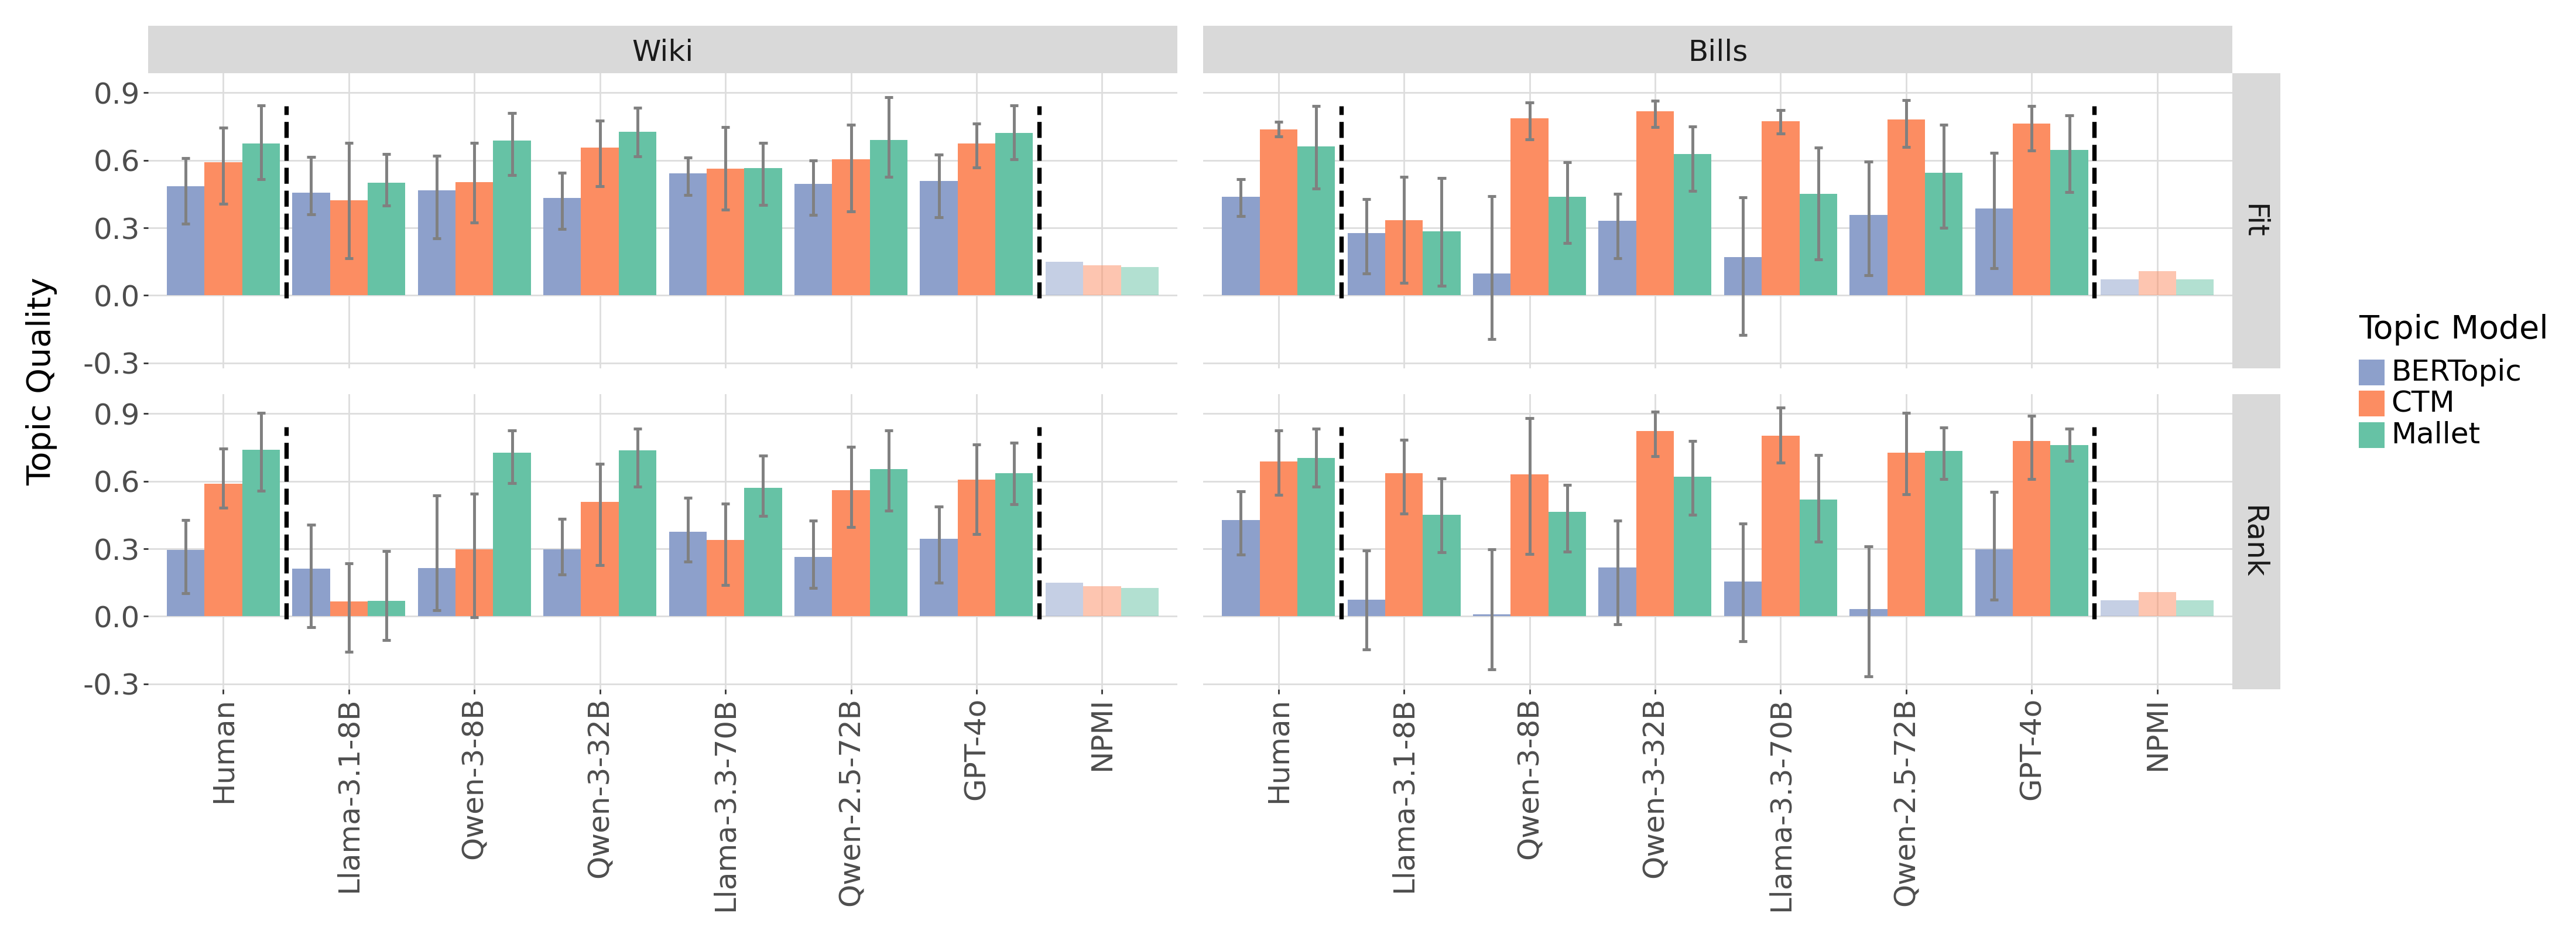

In [23]:
import pandas as pd
from plotnine import *

wiki = dataset_statistics["wiki"]
bills = dataset_statistics["bills"]

wiki['dataset'] = 'Wiki'
bills['dataset'] = 'Bills'

metrics_to_keep = wiki.columns.str.endswith(('_rank', '_fit')) | wiki.columns.isin(['npmi', 'human_fit', 'human_rank'])
ci_cols = wiki.columns[wiki.columns.str.contains('_ci_low|_ci_high')]

wiki_metrics = wiki.loc[:, metrics_to_keep].copy()
bills_metrics = bills.loc[:, metrics_to_keep].copy()

wiki_metrics['model'] = wiki['model']
bills_metrics['model'] = bills['model']
wiki_metrics['dataset'] = 'Wiki'
bills_metrics['dataset'] = 'Bills'

combined = pd.concat([wiki_metrics, bills_metrics], ignore_index=True)

# Melt metric values
long_df = pd.melt(combined, id_vars=['model', 'dataset'], var_name='metric', value_name='rank')

# Melt CI bounds
ci_df_combined = pd.concat([wiki, bills])

ci_low_df = pd.melt(ci_df_combined, id_vars=['model', 'dataset'],
                    value_vars=[c for c in ci_cols if c.endswith('_ci_low')],
                    var_name='metric', value_name='ci_low')
ci_low_df['metric'] = ci_low_df['metric'].str.replace('_ci_low$', '', regex=True)

ci_high_df = pd.melt(ci_df_combined, id_vars=['model', 'dataset'],
                     value_vars=[c for c in ci_cols if c.endswith('_ci_high')],
                     var_name='metric', value_name='ci_high')
ci_high_df['metric'] = ci_high_df['metric'].str.replace('_ci_high$', '', regex=True)

# Merge CI values into long_df
long_df = long_df.merge(ci_low_df, on=['model', 'dataset', 'metric'], how='left')
long_df = long_df.merge(ci_high_df, on=['model', 'dataset', 'metric'], how='left')

# Mapping
model_map = {'mallet': 'Mallet', 'ctm': 'CTM', 'bertopic': 'BERTopic'}
llm_map = {
    'llama-8b': 'Llama-3.1-8B',
    'qwen-3-8b': 'Qwen-3-8B',
    'qwen-3-32b': 'Qwen-3-32B',
    'llama-70b': 'Llama-3.3-70B',
    'qwen-2.5-72b': 'Qwen-2.5-72B',
    'gpt-4o': 'GPT-4o',
    'human': 'Human',
    'npmi': 'NPMI'
}
metric_type_map = {'fit': 'Fit', 'rank': 'Rank'}

def parse_metric(m):
    for typ in metric_type_map:
        if m.endswith(f'_{typ}'):
            source = m.replace(f'_{typ}', '')
            return llm_map.get(source, source), metric_type_map[typ]
    return llm_map.get(m, m), None  # NPMI gets None

long_df[['source', 'metric_type']] = pd.DataFrame(long_df['metric'].apply(parse_metric).tolist())
long_df['model'] = long_df['model'].map(model_map)

# Duplicate NPMI
npmi_df = long_df[long_df['source'] == 'NPMI'].copy()
fit_df = long_df[long_df['metric_type'] == 'Fit'].copy()
rank_df = long_df[long_df['metric_type'] == 'Rank'].copy()

npmi_fit = npmi_df.copy()
npmi_fit['metric_type'] = 'Fit'
npmi_rank = npmi_df.copy()
npmi_rank['metric_type'] = 'Rank'

long_df = pd.concat([fit_df, rank_df, npmi_fit, npmi_rank], ignore_index=True)

# Prettify
long_df['rank'] = pd.to_numeric(long_df['rank'], errors='coerce')
long_df['metric_label'] = long_df['source']
long_df['is_npmi'] = long_df['source'] == 'NPMI'
long_df = long_df[long_df['model'].notna()]

llm_order = ['Llama-3.1-8B', 'Qwen-3-8B', 'Qwen-3-32B', 'Llama-3.3-70B', 'Qwen-2.5-72B', 'GPT-4o']
metric_order = ['Human'] + llm_order + ['NPMI']
long_df['metric_label'] = pd.Categorical(long_df['metric_label'], categories=metric_order, ordered=True)
long_df['metric_type'] = pd.Categorical(long_df['metric_type'].astype(str), categories=['Fit', 'Rank'], ordered=True)
long_df['dataset'] = pd.Categorical(long_df['dataset'].astype(str), categories=['Wiki', 'Bills'], ordered=True)

highlight_df = long_df[long_df['metric_label'].isin(['Human', 'NPMI'])].drop_duplicates(['metric_label', 'dataset', 'metric_type'])
ymin = long_df['rank'].min() - 0.02
ymax = long_df['rank'].max() + 0.02

highlight_rects = geom_rect(
    data=highlight_df,
    mapping=aes(
        xmin='metric_label', xmax='metric_label', ymin=ymin, ymax=ymax
    ),
    fill='#eeeeee', alpha=0.3, inherit_aes=False
)

human_sep_df = long_df[long_df['metric_label'] == 'Human'].drop_duplicates(['dataset', 'metric_type'])
human_sep_df['x'] = 1.5
human_sep_df['ymin'] = ymin
human_sep_df['ymax'] = ymax

human_separator_line = geom_segment(
    data=human_sep_df,
    mapping=aes(x='x', xend='x', y='ymin', yend='ymax'),
    color='black', size=1.5, linetype='dashed', inherit_aes=False
)

npmi_sep_df = long_df[long_df['metric_label'] == 'NPMI'].drop_duplicates(['dataset', 'metric_type'])
npmi_sep_df['x'] = len(metric_order) - 0.5
npmi_sep_df['ymin'] = ymin
npmi_sep_df['ymax'] = ymax

npmi_separator_line = geom_segment(
    data=npmi_sep_df,
    mapping=aes(x='x', xend='x', y='ymin', yend='ymax'),
    color='black', size=1.5, linetype='dashed', inherit_aes=False
)

colors = {
    'Mallet': '#66c2a5',
    'CTM': '#fc8d62',
    'BERTopic': '#8da0cb'
}

plot = (
    ggplot(long_df, aes(x='metric_label', y='rank', fill='model', alpha='is_npmi')) +
    highlight_rects +
    human_separator_line +
    npmi_separator_line +
    geom_col(position='dodge') +
    geom_errorbar(aes(ymin='ci_low', ymax='ci_high'), width=0.2, size=1, color='gray', position=position_dodge(width=0.9)) +
    facet_grid('metric_type ~ dataset', scales='free_x') +
    scale_fill_manual(values=colors) +
    scale_alpha_manual(values={True: 0.5, False: 1.0}) +
    guides(alpha='none') +
    labs(x='', y='Topic Quality', fill='Topic Model') +
    theme(
        figure_size=(22, 8),
        text=element_text(size=24),
        axis_text_x=element_text(rotation=90, size=18),
        axis_text_y=element_text(size=18),
        axis_title=element_text(size=20),
        legend_title=element_text(size=20),
        legend_text=element_text(size=18),
        panel_background=element_rect(fill='white'),
        panel_grid_major=element_line(color="#dddddd"),
        panel_grid_minor=element_blank(),
        strip_text=element_text(size=18)
    )
)

if binarize_tm_probs:
    print("Saving plot with binarized ACL probabilities...")
    plot.save(f"../figures/all_metrics_models_comparison_{corr_metric}_binarized_acl.pdf", dpi=300, bbox_inches='tight')
else:
    plot.save(f"../figures/all_metrics_models_comparison_{corr_metric}_acl.pdf", dpi=300, bbox_inches='tight')

plot

In [22]:
binarize_tm_probs

True